In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats


In [25]:
def log_normal_pdf(x, mu, sigma):
    x = np.asarray(x)
    return -0.5 * np.log(2 * math.pi * sigma**2) - 0.5 * ((x - mu)**2) / (sigma**2)


In [56]:
## Parameters
n_iterations = 5_000_000

mu_coarse = 1.2
sigma_coarse = 5

mu_fine = 1
sigma_fine = 0.05

####
current_theta = np.random.uniform(low=0,high=1)
log_pi_c_current = log_normal_pdf(current_theta, mu_coarse, sigma_coarse)
log_pi_f_current = log_normal_pdf(current_theta, mu_fine, sigma_fine)

counter = 0
samples_fine_model = []
for i in range(n_iterations):
        # independent proposal from the coarse model
        theta_star = np.random.normal(loc=current_theta, scale=1)

        log_pi_c_star = log_normal_pdf(theta_star, mu_coarse, sigma_coarse)

        log_pi_f_star = log_normal_pdf(theta_star, mu_fine, sigma_fine)

        log_alpha_c = log_pi_c_star - log_pi_c_current

        if np.log(np.random.rand()) < log_alpha_c:
        #     stage1_pass += 1
            # Stage 2: correction to the fine target
            log_alpha_f = (log_pi_f_star - log_pi_c_star) - (log_pi_f_current - log_pi_c_current)

            if np.log(np.random.rand()) < log_alpha_f:
                # accept
                current_theta = theta_star
                log_pi_c_current = log_pi_c_star
                log_pi_f_current = log_pi_f_star
                accepted = 1
                counter += 1
            else:
                accepted = 0
            
        samples_fine_model.append(current_theta)

print(f"Alpha: {counter / n_iterations}")

Alpha: 0.063405


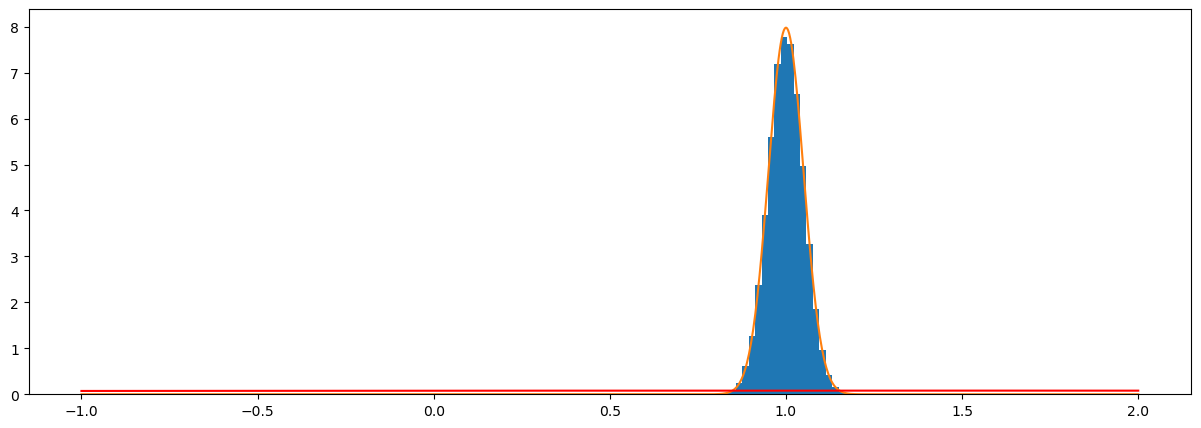

In [58]:
fig, axs = plt.subplots(1, figsize=(15, 5))
x = np.linspace(-1,2,1000)

pdf_fine = stats.norm.pdf(x, loc=mu_fine, scale=sigma_fine)
pdf_coarse = stats.norm.pdf(x, loc=mu_coarse, scale=sigma_coarse)

axs.hist(samples_fine_model,bins= 50,density=True)

axs.plot(x,pdf_fine)
axs.plot(x,pdf_coarse,color ="red")



In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# from Base.lla import dgala
from Base.utilities import *
from elliptic_files.elliptic_mcmc import EllipticMCMCDA
from elliptic_files.utilities import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:

kl =2

obs_points, sol_test = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)

fem_solver = FEMSolver(np.zeros(kl), vert=50,M = kl)
model = torch.load("./models/dgala_mean_hl2_hd90_s20_b10_kl2.pth")

sampler = EllipticMCMCDA(model,fem_solver,obs_points, sol_test,nparameters=kl,marginal=False, 
                         observation_noise=np.sqrt(1e-4), iter_mcmc=1_000_000, iter_da = 10_000, burnin=None, 
                        proposal_type="random_walk",prior_type = "uniform",uniform_limit=2,my_reg = 1e-3, 
                        step_size=0.001,device=device)

#sampler.run_chain(verbose=True)
sampler.run_da(verbose=True)

Starting DA Montecarlo....


Running Delayed Acceptance: 100%|██████████| 10000/10000 [01:56<00:00, 85.81step/s, acceptance_rate=0.1408, proposal_variance=0.0097]

Times inner step 10000.0000, Acceptance Rate: 0.1408,Acceptance Rate First Step 0.5358


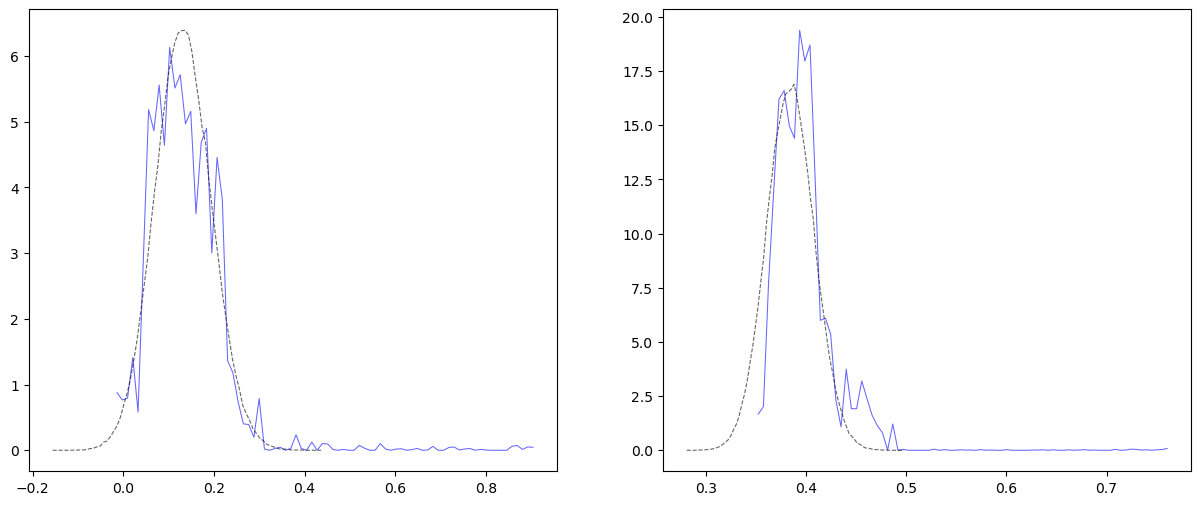

In [10]:
import torch

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{2}_{0}.npy')
samples_model = sampler.fine_model_chain.numpy()
for j in range(2):
        bin_centers, counts = histogram_(samples_model[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")


In [7]:
kl =2

obs_points, sol_test = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)

fem_solver = FEMSolver(np.zeros(kl), vert=50,M = kl)
model = torch.load("./models/dgala_marginal_hl2_hd90_s20_b10_kl2.pth")
model.model.set_last_layer("output_layer")

sampler = EllipticMCMCDA(model,fem_solver,obs_points, sol_test,nparameters=kl,marginal=True, 
                         observation_noise=np.sqrt(1e-4), iter_mcmc=1_000_000, iter_da = 10000, burnin=None, 
                        proposal_type="random_walk",prior_type = "uniform",uniform_limit=2,my_reg = 1e-3, 
                        step_size=0.0636,device=device)

#sampler.run_chain(verbose=True)
sampler.run_da(verbose=True)

Starting DA Montecarlo....


Running Delayed Acceptance: 100%|██████████| 10000/10000 [04:15<00:00, 39.15step/s, acceptance_rate=0.2367, proposal_variance=0.0529]

Times inner step 10000.0000, Acceptance Rate: 0.2367,Acceptance Rate First Step 0.9248


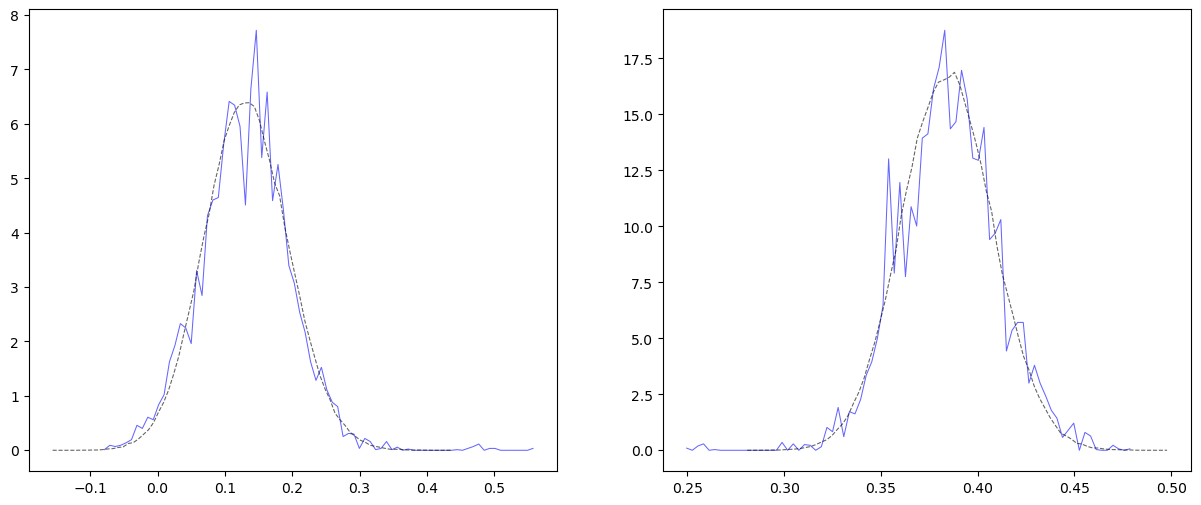

In [8]:
import torch

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{2}_{0}.npy')
samples_model = sampler.fine_model_chain.numpy()
for j in range(2):
        bin_centers, counts = histogram_(samples_model[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")


In [9]:
kl =2

obs_points, sol_test = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)

fem_solver = FEMSolver(np.zeros(kl), vert=50,M = kl)
model = torch.load("./models/dgala_marginal_hl2_hd90_s20_b10_kl2.pth")
model.model.set_last_layer("output_layer")

sampler = EllipticMCMCDA(model,fem_solver,obs_points, sol_test,nparameters=kl,marginal=True, 
                         observation_noise=np.sqrt(1e-4), iter_mcmc=1_000_000, iter_da = 10_000, burnin=None, 
                        proposal_type="random_walk",prior_type = "uniform",uniform_limit=2,my_reg = 1e-3, 
                        step_size=0.5345,device=device)

#sampler.run_chain(verbose=True)
sampler.run_da(verbose=True)

Starting DA Montecarlo....


Running Delayed Acceptance: 100%|██████████| 10000/10000 [07:33<00:00, 22.07step/s, acceptance_rate=0.0232, proposal_variance=0.5345]

Times inner step 10000.0000, Acceptance Rate: 0.0232,Acceptance Rate First Step 0.1954


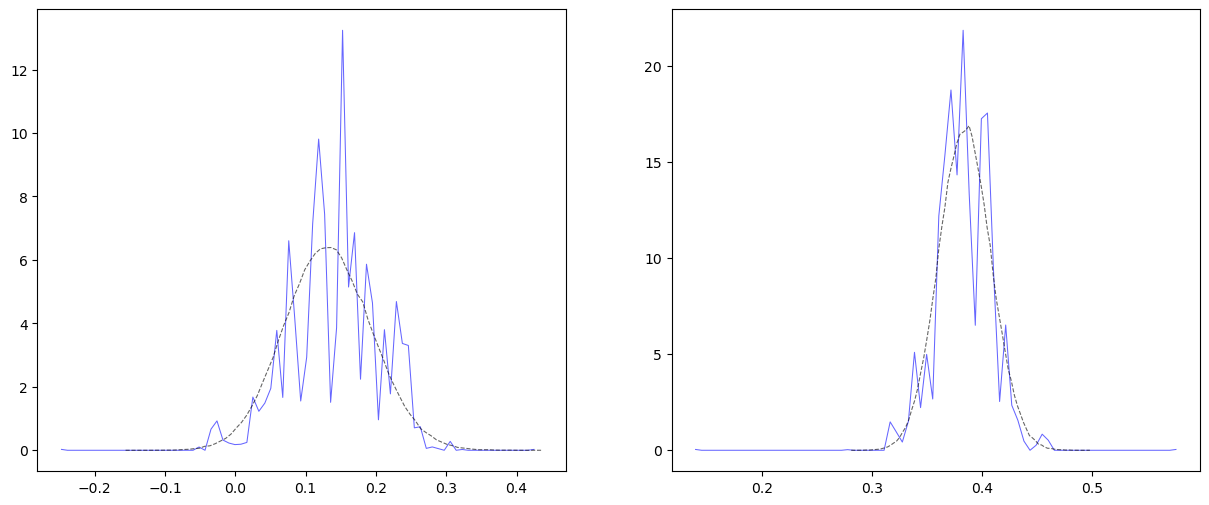

In [10]:
import torch

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{2}_{0}.npy')
samples_model = torch.tensor(sampler.fine_chain).numpy()
for j in range(2):
        bin_centers, counts = histogram_(samples_model[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")


# 50

In [3]:
kl =2

obs_points, sol_test = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)

fem_solver = FEMSolver(np.zeros(kl), vert=50,M = kl)
model = torch.load("./models/dgala_mean_hl2_hd90_s50_b10_kl2.pth")

sampler = EllipticMCMCDA(model,fem_solver,obs_points, sol_test,nparameters=kl,marginal=False, 
                         observation_noise=np.sqrt(1e-4), iter_mcmc=1_000_000, iter_da = 50000, burnin=None, 
                        proposal_type="random_walk",prior_type = "uniform",uniform_limit=2,my_reg = 1e-3, 
                        step_size=0.0673,device=device)

#sampler.run_chain(verbose=True)
sampler.run_da(verbose=True)

Starting DA Montecarlo....


Running Delayed Acceptance: 100%|██████████| 50000/50000 [09:48<00:00, 84.89step/s, acceptance_rate=0.0161, proposal_variance=0.0673]

Times inner step 50000.0000, Acceptance Rate: 0.0161,Acceptance Rate First Step 0.5031


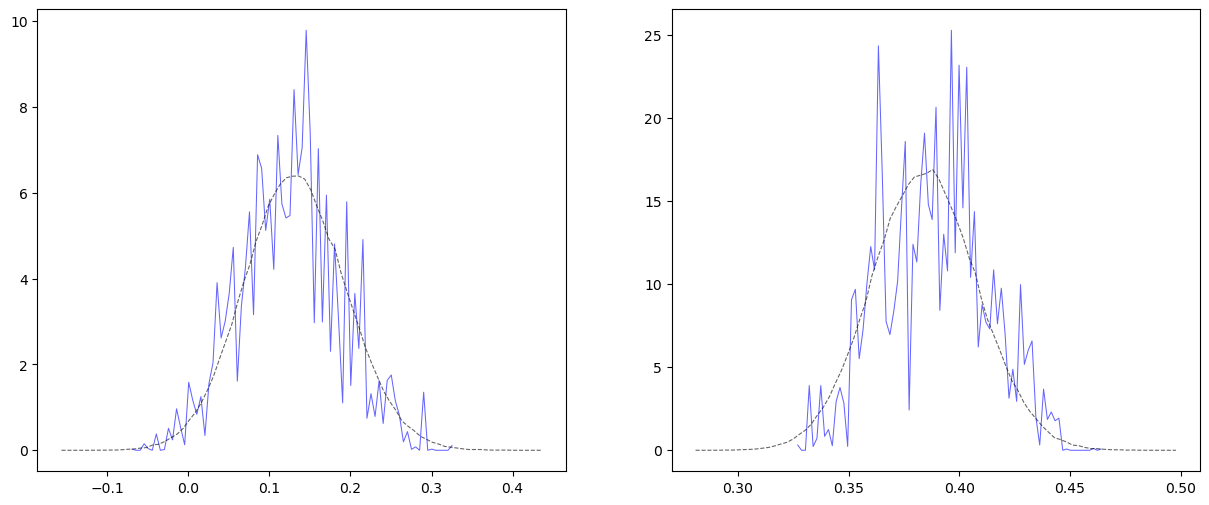

In [4]:
import torch

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{2}_{0}.npy')
samples_model = torch.tensor(sampler.fine_chain).numpy()
for j in range(2):
        bin_centers, counts = histogram_(samples_model[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")


In [2]:
kl =2

obs_points, sol_test = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)

fem_solver = FEMSolver(np.zeros(kl), vert=50,M = kl)
model = torch.load("./models/dgala_marginal_hl2_hd90_s50_b10_kl2.pth")
model.model.set_last_layer("output_layer")

sampler = EllipticMCMCDA(model,fem_solver,obs_points, sol_test,nparameters=kl,marginal=True, 
                         observation_noise=np.sqrt(1e-4), iter_mcmc=1_000_000, iter_da = 10_000, burnin=None, 
                        proposal_type="random_walk",prior_type = "uniform",uniform_limit=2,my_reg = 1e-3, 
                        step_size=0.0673,device=device)

#sampler.run_chain(verbose=True)
sampler.run_da(verbose=True)

Starting DA Montecarlo....


Running Delayed Acceptance: 100%|██████████| 10000/10000 [05:00<00:00, 33.33step/s, acceptance_rate=0.2165, proposal_variance=0.0673]

Times inner step 10000.0000, Acceptance Rate: 0.2165,Acceptance Rate First Step 0.7016


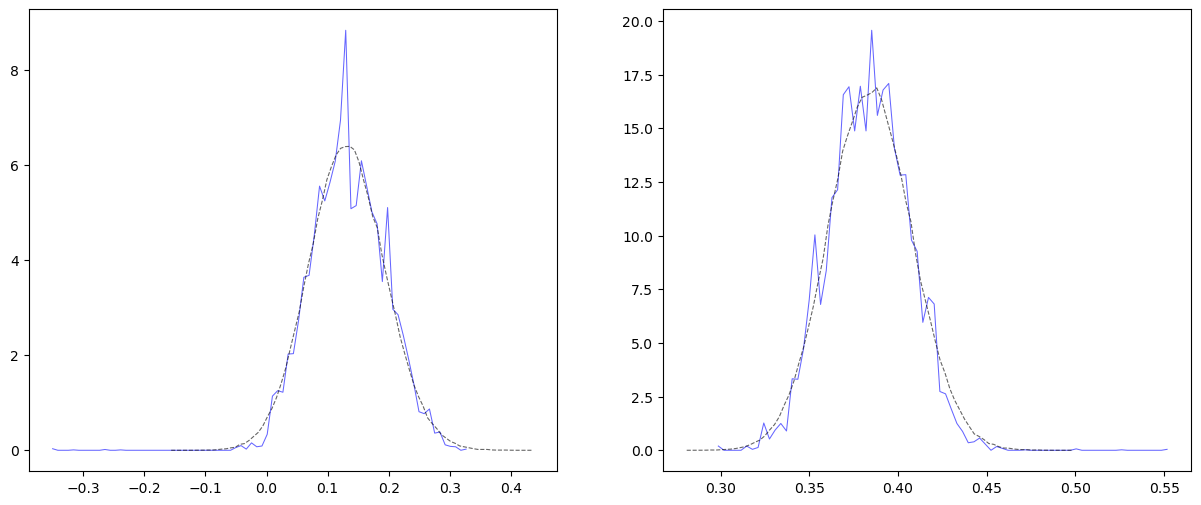

In [3]:
import torch

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{2}_{0}.npy')
samples_model = torch.tensor(sampler.fine_chain).numpy()
for j in range(2):
        bin_centers, counts = histogram_(samples_model[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")


# 100

In [2]:
kl =2

obs_points, sol_test = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)

fem_solver = FEMSolver(np.zeros(kl), vert=50,M = kl)
model = torch.load("./models/dgala_mean_hl2_hd90_s100_b100_kl2.pth")

sampler = EllipticMCMCDA(model,fem_solver,obs_points, sol_test,nparameters=kl,marginal=False, 
                         observation_noise=np.sqrt(1e-4), iter_mcmc=1_000_000, iter_da = 10_000, burnin=None, 
                        proposal_type="random_walk",prior_type = "uniform",uniform_limit=2,my_reg = 1e-3, 
                        step_size=0.0617,device=device)

#sampler.run_chain(verbose=True)
sampler.run_da(verbose=True)

Starting DA Montecarlo....


Running Delayed Acceptance: 100%|██████████| 10000/10000 [02:10<00:00, 76.46step/s, acceptance_rate=0.7500, proposal_variance=0.0617]

Times inner step 10000.0000, Acceptance Rate: 0.7500,Acceptance Rate First Step 0.1988


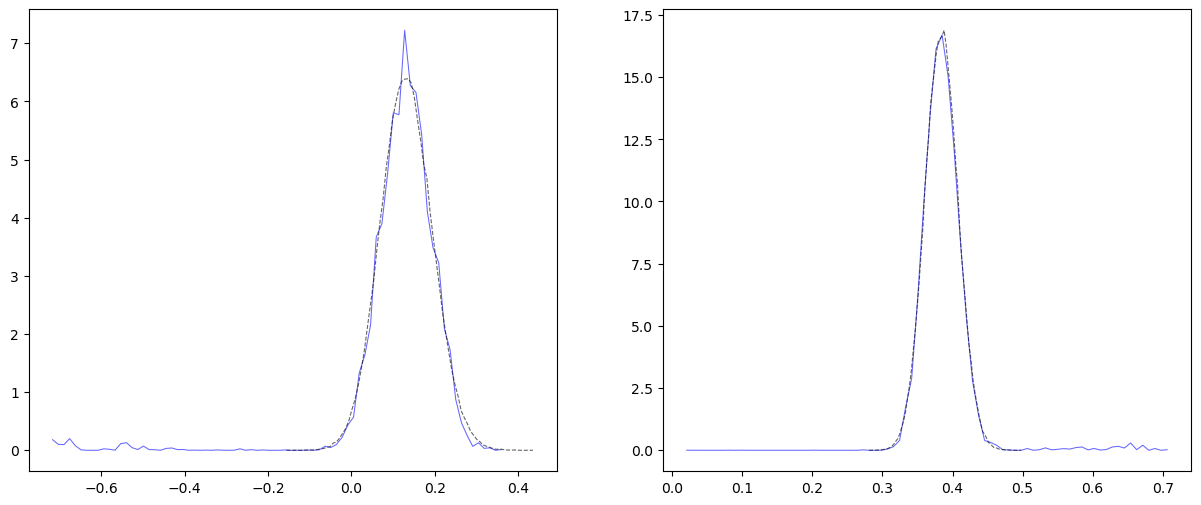

In [3]:
import torch

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{2}_{0}.npy')
samples_model = torch.tensor(sampler.fine_chain).numpy()
for j in range(2):
        bin_centers, counts = histogram_(samples_model[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")


In [6]:
kl =2

obs_points, sol_test = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)

fem_solver = FEMSolver(np.zeros(kl), vert=50,M = kl)
model = torch.load("./models/dgala_marginal_hl2_hd90_s100_b100_kl2.pth")
model.model.set_last_layer("output_layer")

sampler = EllipticMCMCDA(model,fem_solver,obs_points, sol_test,nparameters=kl,marginal=True, 
                         observation_noise=np.sqrt(1e-4), iter_mcmc=1_000_000, iter_da = 10_000, burnin=None, 
                        proposal_type="random_walk",prior_type = "uniform",uniform_limit=2,my_reg = 1e-3, 
                        step_size=0.0617,device=device)

#sampler.run_chain(verbose=True)
sampler.run_da(verbose=True)

Starting DA Montecarlo....


Running Delayed Acceptance: 100%|██████████| 10000/10000 [05:10<00:00, 32.19step/s, acceptance_rate=0.2305, proposal_variance=0.0617]

Times inner step 10000.0000, Acceptance Rate: 0.2305,Acceptance Rate First Step 0.7908


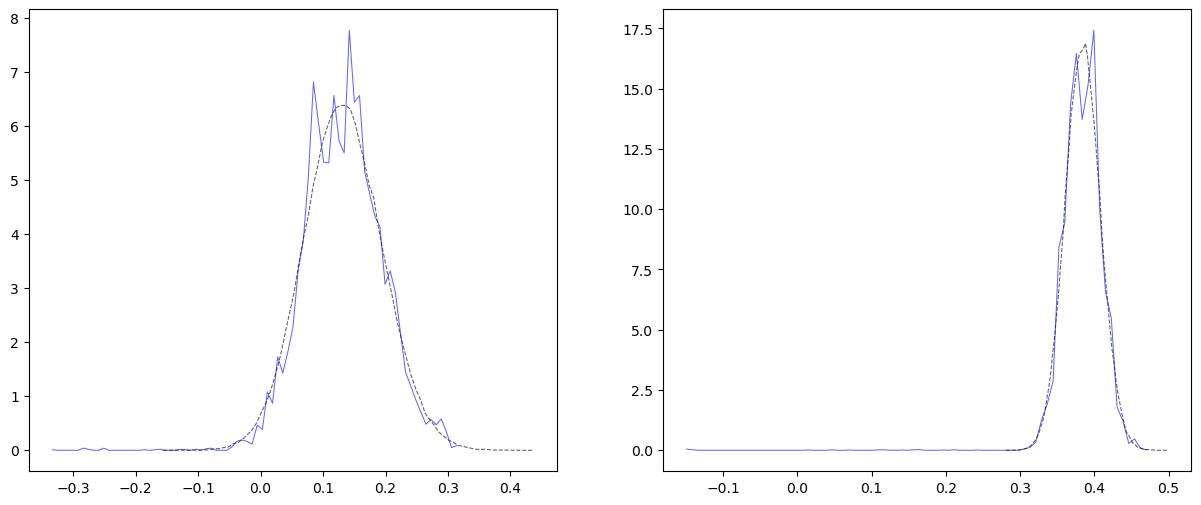

In [7]:
import torch

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex="col")

sample = np.load(f'./results/FEM_mcmc_kl{2}_{0}.npy')
samples_model = torch.tensor(sampler.fine_chain).numpy()
for j in range(2):
        bin_centers, counts = histogram_(samples_model[:, j], bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                    color="blue", label=f"GP" if j == 0 else None)  # Label only once per N
        
        bin_centers, counts = histogram_(sample[:, j],bins=80)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")
